Helmholtz Equation
===
Consider the problem of finding $u$ satisfying 

$$
-\Delta u - \omega^2 u = f \qquad \text{ in } \mathbb{R}^2
$$

together with the Sommerfeld (outgoing) radiation condition at infinity

$$
\lim_{r \to \infty} r^{1/2}
\bigg( 
\frac{\partial u }{ \partial r} - i \omega u 
\bigg) = 0
$$

where $r$ is the radial coordinate.  

In [5]:
from ngsolve import *
from ngsolve.webgui import Draw
from math import pi
import numpy as np
from scipy.sparse import csr_matrix

In [6]:
f = 10
omega = 2*pi*f
h = 1/(12*f)

In [7]:
omega*h

0.5235987755982988

In [8]:
from netgen.geom2d import CSG2d, Rectangle
help(Rectangle)


Help on built-in function Rectangle in module netgen.libngpy._geom2d:

Rectangle(...) method of builtins.PyCapsule instance
    Rectangle(pmin: netgen.libngpy._meshing.Point2d, pmax: netgen.libngpy._meshing.Point2d, mat: str = '', bc: str = '', bottom: Optional[str] = None, right: Optional[str] = None, top: Optional[str] = None, left: Optional[str] = None) -> netgen.libngpy._geom2d.Solid2d



In [9]:
domain_size = 1.0    
pml_thickness = 0.05    
geo = CSG2d()

inner = Rectangle( pmin=(0,0), pmax=(domain_size, domain_size), mat="inner", bc="bc_omega" )
out = Rectangle( pmin=(-pml_thickness,-pml_thickness), pmax=(domain_size + pml_thickness,domain_size + pml_thickness), mat="total", bc="out_bc" )

pmlregion = out - inner
pmlregion.Mat("pmlregion")

geo.Add(inner)
geo.Add(pmlregion)
mesh = Mesh(geo.GenerateMesh(maxh=h))
Draw(mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [10]:
mesh.nv, mesh.ne

(19997, 39464)

The PML facility in NGSolve implements a complex coordinate transformation on a given mesh region (which in  this example is  `pmlregion`). When this complex variable change is applied to the outgoing solution in the PML region,  it becomes a a function that decays exponentially as $r \to \infty$, allowing us to truncate the unbounded domain.

With the following single line, we tell NGSolve to turn on this coordinate transformation. 

In [11]:
mesh.SetPML(pml.Cartesian((0,0),(1,1),1j), "pmlregion")

In [12]:
fes = H1(mesh, order=1, complex=True)
print ("number of dofs =", fes.ndof)

number of dofs = 19997


In [13]:
u = fes.TrialFunction()
v = fes.TestFunction()

a = BilinearForm(fes)
a += (grad(u)*grad(v)-omega**2*u*v)*dx
a.Assemble()
# print (csr_matrix(a.mat.CSR()))

In [14]:

source = 1/(h**2)*exp(-(300**2)*((x-0.5)*(x-0.5) + (y-0.5)*(y-0.5)))
f = LinearForm(source*v*dx).Assemble()
# print (np.array(f.vec))

In [15]:
gfu = GridFunction(fes)
gfu.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec

In [16]:
Draw(gfu, mesh, order=3, animate_complex=True)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

BaseWebGuiScene

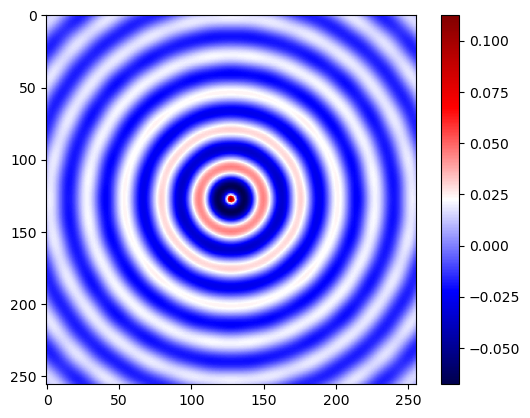

In [17]:
import matplotlib.pyplot as plt
N = 256
X = np.linspace(0, 1, N)
u = np.zeros((N,N))
for i in range(N):
    Y = np.ones_like(X) * X[i]
    u[:,i] = gfu(mesh(X, Y))[:,0].real
plt.imshow(np.rot90(u), cmap="seismic")
plt.colorbar()